# Introduction and motivation

Gaussian Processes (GPs) are a very useful type of model which has several attractive features. First, GPs offer a method for doing exact inference on non-linear regression problems. Second, model accuracy and complexity are naturally balanced in GPs, preventing overfitting while preserving model capacity. Third, model comparison can be done rigorously by comparing the marginal log-likelihoods of different GPs.

However, the computational complexity of fitting a gaussian process scales as $\mathcal{O}(N^3)$ with the number of datapoints, $N$, because of the inversion of the covariance matrix. For example, the predictive mean and covariance for a GP with kernel $k(\cdot, \cdot)$ and train-data covariance matrix $\mathbf{K}$ are

$$ \begin{align} \mu &=  k(x^* ,\mathbf{x})^\top [\mathbf{K} + \sigma^2_{noise} \mathbf{I}]^{-1} \mathbf{y} \\
\sigma^2 &= k(\mathbf{x}^*, \mathbf{x}^*) + \sigma^2_{noise} + k(x^* ,\mathbf{x})^\top [\mathbf{K} + \sigma^2_{noise} \mathbf{I}]^{-1} k(x^*,\mathbf{x}) \end{align}$$

both of which involve the inversion of an $N\times N$ matrix, and a $\mathcal{O}(N^3)$ complexity. Even worse, learning the hyperparameters of the covariance matrix involves several such $\mathcal{O}(N^3)$ inversions. Therefore, vanilla GPs unwieldy for many datasets of practical interest. Many approximation schemes have been devised to make GPs tractable for large datasets. In this notebook we present an elegant and general variational inference method developed by Michalis Titsias ([paper](http://proceedings.mlr.press/v5/titsias09a/titsias09a.pdf)). This is based on using $M < N$ pseudo-points to approximate the dataset, allowing learning and prediction in $\mathcal{O}(NM^2)$ time. The positions of the pseudo-points are treated as variational parameters and are opitimised along with the hyperparameters.

We found that the original paper did not mention some important implementation details including the Woodbury Identity and the Matrix Determinant Lemma, which are necessary to achieve $\mathcal{O}(NM^2)$ complexity (possibly assuming these are elemetary and known to the reader). Handling matrix multiplications to avoid $N^2$ or $N^3$ complexity was also non-trivial.

# The variational approximation for Sparse Gaussian Processes

Consider the regression problem where observations $\mathbf{y}$ are modelled as $y_i = f(x_i) + \epsilon_i$, where $f \sim \mathcal{GP}(0, k(\cdot, \cdot))$ is an (unobserved) function with a GP prior - with mean 0 and covariance $k$ with hyperparameters $\boldsymbol{\theta}$ - and $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$ are iid noise values.

## Brief summary

### 1. Conditional independence assumption
In the sparse variational approximation, Titsias considers additional function variables $\mathbf{f}_m$ at different inputs locations and then makes the modelling assumption that the observations $\mathbf{y}$ are independent from the latent function values $\mathbf{f}$ given the inducing points $\mathbf{f}_m$. This allows an approximate predictive distribution which can be calculated in $\mathcal{O}(NM^2)$ time, where $M$ is the number of inducing points. Intuitively, the conditional independence assumption sidesteps the $\mathcal{O}(N^3)$ matrix inversion because the observations do not depend directly on the $N$ function values $\mathbf{f}$ directly, but only indirectly through $\mathbf{f}_m$.

### 2. Choice of variational posterior
The method requires a distribution over the inducing points, which is obtained by approximating the true posterior $p(\mathbf{f}, \mathbf{f}_m \vert \mathbf{y})$ using the variational posterior $q(\mathbf{f}, \mathbf{f}_m) = p(\mathbf{f} | \mathbf{f}_m) q(\mathbf{f}_m)$ - chosen to simplify the maths - and an optimal $q(\mathbf{f}_m)$ is chosen by minimising the KL divergence between the variational and the true posterior.

### 3. Optimisation of inducing points
The quality of this approximation will clearly depend on the location of the inducing points, which are optimised together with the hyperparameters $\boldsymbol{theta}$. This is achieved by optimsing a lower-bound to the log-marginal likelihood $\log p(\mathbf{y})$, the Free Energy $\mathcal{F}$. This process gives a computationally tractable approximation to the full GP.

## In detail

Consider the predictive distribution
\begin{align}
p(y^*\vert \mathbf{y}) = \int p(y^*\vert \mathbf{f}) p(\mathbf{f} \vert \mathbf{y}) \text{d}\mathbf{f}
\end{align}
By introducing inducing variables $\mathbf{f}_m$ and making the conditional independence assumption $p(\mathbf{f} \vert \mathbf{f}_m, \mathbf{y}) = p(\mathbf{f} \vert \mathbf{f}_m)$ we obtain

\begin{align}
p(y^*\vert \mathbf{y}) &= \int p(y^*\vert \mathbf{f}, \mathbf{f}_m) p(\mathbf{f}, \mathbf{f}_m  \vert \mathbf{y}) \text{d}\mathbf{f}_m\text{d}\mathbf{f}\\
&= \int p(y^*\vert \mathbf{f}_m) p(\mathbf{f}  \vert \mathbf{f}_m)p(\mathbf{f}_m\vert\mathbf{y}) \text{d}\mathbf{f}_m\text{d}\mathbf{f}\\
&= \int p(y^*\vert \mathbf{f}_m) p(\mathbf{f}_m\vert\mathbf{y}) \text{d}\mathbf{f}_m\\
\end{align}

To evaluate the integrals we need the posterior $p(\mathbf{f}_m, \mathbf{f} \vert\mathbf{y}) \approx p(\mathbf{f}  \vert \mathbf{f}_m)p(\mathbf{f}_m\vert\mathbf{y}) $. In the sparse variational approximation this is obtained by selecting the variational posterior $q(\mathbf{f}, \mathbf{f}_m) = p(\mathbf{f} | \mathbf{f}_m) q(\mathbf{f}_m)$ - where $q(\mathbf{f}_m)$ is a free variational distribution - and minimising its KL divergence to the approximate posterior:

\begin{align}
\text{KL}(q(\mathbf{f}, \mathbf{f}_m) \vert\vert p(\mathbf{f}_m, \mathbf{f} \vert\mathbf{y})) &= - \int p(\mathbf{f} | \mathbf{f}_m) q(\mathbf{f}_m)\log \frac{p(\mathbf{f}, \mathbf{f}_m\vert\mathbf{y})}{p(\mathbf{f} | \mathbf{f}_m) q(\mathbf{f}_m)} \text{d}\mathbf{f}_m\text{d}\mathbf{f}
\end{align}

Equivalently, we can maximise the Free Energy:

\begin{align}
\text{KL}(q(\mathbf{f}, \mathbf{f}_m) \vert\vert p(\mathbf{f}_m, \mathbf{f} \vert\mathbf{y})) &= \log p(\mathbf{y}) - \int p(\mathbf{f} | \mathbf{f}_m) q(\mathbf{f}_m)\log \frac{p(\mathbf{y}, \mathbf{f}, \mathbf{f}_m)}{p(\mathbf{f} | \mathbf{f}_m) q(\mathbf{f}_m)} \text{d}\mathbf{f}_m\text{d}\mathbf{f}\\
~\\
\log p(\mathbf{y}) &= \underbrace{\int p(\mathbf{f} | \mathbf{f}_m) q(\mathbf{f}_m)\log \frac{p(\mathbf{y}, \mathbf{f}, \mathbf{f}_m)}{p(\mathbf{f} | \mathbf{f}_m) q(\mathbf{f}_m)} \text{d}\mathbf{f}_m\text{d}\mathbf{f}}_{\text{Free energy } \mathcal{F}} + \text{KL}(q(\mathbf{f}, \mathbf{f}_m) \vert\vert p(\mathbf{f}_m, \mathbf{f} \vert\mathbf{y}))\\
\end{align}

Since the KL is nonnegative, the free energy bounds the log-marginal likelihood from below, so maximising the log-likelihood guarantees that the log-marginal likelihood is at least as high.

\begin{align}
\mathcal{F}(q(\mathbf{f}_m)) &= \int p(\mathbf{f} | \mathbf{f}_m) q(\mathbf{f}_m)\log \frac{p(\mathbf{y}\vert\mathbf{f})p(\mathbf{f}_m)}{q(\mathbf{f}_m)} \text{d}\mathbf{f}_m\text{d}\mathbf{f}\\
~\\
&= \int q(\mathbf{f}_m)\log \frac{p(\mathbf{f}_m)}{q(\mathbf{f}_m)} \text{d}\mathbf{f}_m\text{d}\mathbf{f} + \int p(\mathbf{f} | \mathbf{f}_m) q(\mathbf{f}_m)\log p(\mathbf{y}\vert\mathbf{f}) \text{d}\mathbf{f}_m\text{d}\mathbf{f}
\end{align}

Taking the variational derivative of $\mathcal{F} - \lambda \left[\int q(\mathbf{f}_m)\text{d}\mathbf{f}_m - 1\right]$ with respect to $q$ and equating to 0, where we have introduced the Lagrange multiplier $\lambda$ to enforce the cosntraint $\int q(\mathbf{f}_m)\text{d}\mathbf{f}_m = 1$:

\begin{align}
\int p(\mathbf{f} | \mathbf{f}_m) \left[\log p(\mathbf{f}_m) - \log q(\mathbf{f}_m) - 1 \right] \text{d}\mathbf{f} + \int p(\mathbf{f} | \mathbf{f}_m) \log p(\mathbf{y}\vert\mathbf{f}) \text{d}\mathbf{f} + \lambda = 0
\end{align}

Rearranging and solving for $q(\mathbf{f}_m)$:

\begin{align}
q(\mathbf{f}_m) = \frac{p(\mathbf{f}_m)}{Z}\exp \left[ \int p(\mathbf{f} | \mathbf{f}_m) \log p(\mathbf{y}\vert\mathbf{f}) \text{d}\mathbf{f} \right]
\end{align}

Where $Z$ is the appropriate normalising constant. Subsituting this in the expression for the free energy we obtain:

\begin{align}
\mathcal{F}(q(\mathbf{f}_m)) = \log Z = \log\left[ \int p(\mathbf{f}_m) \exp \int p(\mathbf{f} | \mathbf{f}_m) \log p(\mathbf{y}\vert\mathbf{f}) \text{d}\mathbf{f} \text{d}\mathbf{f}_m \right].
\end{align}

To evaluate the expression for $q(\mathbf{f}_m)$ we first calculate the integral inside the exponential:

\begin{align}
\int p(\mathbf{f} | \mathbf{f}_m) \log p(\mathbf{y}\vert\mathbf{f}) \text{d}\mathbf{f} &= \int p(\mathbf{f} | \mathbf{f}_m) \left[-\frac{1}{2}\log(2\pi\sigma^2) -\frac{1}{2\sigma^2} (\mathbf{y} - \mathbf{f})^\top(\mathbf{y} - \mathbf{f}) \right] \text{d}\mathbf{f}\\
&= -\frac{1}{2}\log(2\pi\sigma^2) + \int p(\mathbf{f} | \mathbf{f}_m) \text{Tr}\left[-\frac{1}{2\sigma^2} (\mathbf{y}\mathbf{y}^\top - 2\mathbf{f}\mathbf{y}^\top + \mathbf{f}\mathbf{f}^\top) \right] \text{d}\mathbf{f}\\
&= -\frac{1}{2}\log(2\pi\sigma^2) -\frac{1}{2\sigma^2} \text{Tr}\left[ (\mathbf{y}\mathbf{y}^\top - 2\mathbf{a}\mathbf{y}^\top + \mathbf{B}) \right] \text{d}\mathbf{f}\\
&= \log\mathcal{N}(\mathbf{y}; \mathbf{A}\mathbf{f}_m, \sigma^2I) -\frac{1}{2\sigma^2} \text{Tr}\left(\mathbf{B} \right)
\end{align}

where $\mathbf{A} = K_{nm}K^{-1}_{mm}$ and $\mathbf{B} = K_{nn} - K_{nm}K^{-1}_{mm}K_{mn}$. We can obtain $q(\mathbf{f}_m)$ by noting that $q(\mathbf{f}_m) \propto \mathcal{N}(\mathbf{f}_m; \mathbf{0}, K_{mm})\mathcal{N}(\mathbf{y}; \mathbf{A}\mathbf{f}_m, \sigma^2 I)$, writing out the exponent and completing the square to obtain:

\begin{align}
q(\mathbf{f}_m) = \mathcal{N}(\mathbf{f}_m; \sigma^{-2} K_{mm}\Sigma^{-1}K_{mn}\mathbf{y}, K_{mm}\Sigma^{-1}K_{mm})
\end{align}

where $\Sigma = K_{nm}K^{-1}_{mm}K_{mn} + \sigma^2 I$. We can also solve for the free energy to obtain

\begin{align}
\mathcal{F}(q(\mathbf{f}_m)) &= \log\left[ \int p(\mathbf{f}_m) \exp \int p(\mathbf{f} | \mathbf{f}_m) \log p(\mathbf{y}\vert\mathbf{f}) \text{d}\mathbf{f} \text{d}\mathbf{f}_m \right]\\
&= \log\left[ \int p(\mathbf{f}_m) \exp \left( \log\mathcal{N}(\mathbf{y}; \mathbf{A}\mathbf{f}_m, \sigma^2I) -\frac{1}{2\sigma^2} \text{Tr}\left(\mathbf{B} \right) \right) \right] \text{d}\mathbf{f}_m.\\
\end{align}

Using the fact that a covolution of gaussians is also gaussian we obtain:

\begin{align}
\mathcal{F}(q(\mathbf{f}_m)) = \mathcal{N}(\mathbf{y}; \mathbf{0}, K_{nm}K_{mm}^{-1}K_{mn} + \sigma^2I) - \frac{1}{2\sigma^2} \text{Tr}\left(K_{nn} - K_{nm}K^{-1}_{mm}K_{mn} \right).\\
\end{align}

Finally, the predictive distribution using the approximate posterior is again a convolution of gaussians:

\begin{align}
p(y^*\vert \mathbf{y}) &= \int p(y^*\vert \mathbf{f}_m) q(\mathbf{f}_m) \text{d}\mathbf{f}_m\\
\end{align}

In [1]:
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
from tqdm import tqdm_notebook as tqdm
import pandas as pd

from utils import fast_matrix_det, fast_quadratic_form, woodbury, rbf, IncompatibleShapeError

DATA_DIR = "../data/sparse/"

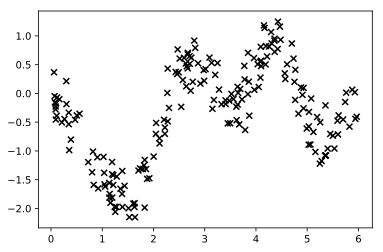

(200, 1)

In [2]:
X_n = pd.read_csv(DATA_DIR + '/train_inputs', header=None, sep='\s+').values
Y = pd.read_csv(DATA_DIR + '/train_outputs', header=None, sep='\s+').values

plt.scatter(X_n, Y, marker='x', color='k')
plt.show()

Y.shape

In [3]:
def get_predictive_variational_gp(X_m, X_n, Y, sigma_noise, sigma_f, length_scale):
    """
    Closure that gives back the predictive mean and covariance function for a
    sparse GP.
    
    X_m          - M x H matrix: M inducing points of dimension H
    X_n          - N x H matrix: N input data points of dimension H
    Y            - N x D matrix: N output data points of dimension D
    sigma_noise  - scalar: assumed measurement noise on each output dimension
    sigma_f      - scalar: scale factor of RBF kernel
    length_scale - scalar: length scale of RBF kernel
    
    RBF kernel:
    
    k(x_i, x_j) = sigma_f^2 * exp( -1. / (2 * length_scale^2) * (x_i - x_j)'(x_i - x_j))
    
    """
    # ======================================================================
    # Ensure the input has the correct size
    # ======================================================================
    if len(X_m.shape) != 2:
        raise IncompatibleShapeError(
            "X_m rank of shape must be 2 not: {}".format(len(X_m.shape)))
        
    if len(X_n.shape) != 2:
        raise IncompatibleShapeError(
            "X_n rank of shape must be 2 not: {}".format(len(X_n.shape)))
       
    if len(Y.shape) != 2:
        raise IncompatibleShapeError(
            "Y rank of shape must be 2 not: {}".format(len(Y.shape)))
        
    m, h = X_m.shape
    n, d = Y.shape
    n_, h_ = X_n.shape
    
    if h != h_:
        raise IncompatibleShapeError(
            "X_m and X_n must share the same 2nd dimension: {} and {} must match".format(h, h_))
    
    if n != n_:
        raise IncompatibleShapeError(
            "Y and X_n must share the same 1nd dimension: {} and {} must match".format(n, n_))
    
    # ======================================================================
    # Do stuff
    # ======================================================================

    # Joint covariance of q(f_n, f_m)
    K = rbf(np.concatenate((X_n, X_m), axis=0), sigma_f, length_scale)
    
    K_nn = K[:n, :n]
    K_mm = K[n:, n:]
    K_nm = K[:n, n:]
    K_mm_inv = np.linalg.inv(K_mm)
    
    Sigma = np.linalg.inv(K_mm + sigma_noise ** -2. * np.dot(K_nm.T, K_nm))
    mu = sigma_noise ** -2. * np.dot(K_mm, np.dot(np.dot(Sigma, K_nm.T), Y.reshape(n, -1)))
    
    
    # Produce predictive mean and covariance functions
    
    def mu_fn(x_preds):
        """
        x_preds - P x H matrix: P predictive input points of dimension H
        """
        
        if len(x_preds.shape) != 2:
            raise IncompatibleShapeError(
                "x_preds rank of shape must be 2 not: {}".format(len(x_preds.shape)))
            
        p, h__ = x_preds.shape
        
        if h != h__:
            raise IncompatibleShapeError(
                "x_preds and X_m must share the same 2nd dimension: {} and {} must match".format(h, h__))

        K_ = rbf(np.concatenate((x_preds, X_m), axis=0), sigma_f, length_scale)
        K_xm = K_[:p, p:]
        
        return np.dot(np.dot(K_xm, K_mm_inv), mu)
    
    def cov_fn(x_preds):
        """
        x_preds - P x H matrix: P predictive input points of dimension H
        """
        
        if len(x_preds.shape) != 2:
            raise IncompatibleShapeError(
                "x_preds rank of shape must be 2 not: {}".format(len(x_preds.shape)))
            
        p, h__ = x_preds.shape
        
        if h != h__:
            raise IncompatibleShapeError(
                "x_preds and X_m must share the same 2nd dimension: {} and {} must match".format(h, h__))
        
        
        K_ = rbf(np.concatenate((x_preds, X_m), axis=0), sigma_f, length_scale)
        K_xx = K_[:p, :p]
        K_xm = K_[:p, p:]
        
        return K_xx + sigma_noise ** 2. - np.dot(np.dot(K_xm, K_mm_inv), K_xm.T) \
                + np.dot(np.dot(K_xm, Sigma), K_xm.T)
    
    return mu_fn, cov_fn

In [4]:
def gp_log_prob(X, Y, sigma_noise, sigma_f, length_scale, verbose=False):
    """
    Log probability of an RBF-kernel GP. If the output is vector-valued, then
    the individual dimensions are assumed independent.
    
    X            - N x H matrix: N input data points of dimension H
    Y            - N x D matrix: N output data points of dimension D
    sigma_noise  - scalar: assumed measurement noise on each output dimension
    sigma_f      - scalar: scale factor of RBF kernel
    length_scale - scalar: length scale of RBF kernel
    
    RBF kernel:
    
    k(x_i, x_j) = sigma_f^2 * exp( -1. / (2 * length_scale^2) * (x_i - x_j)'(x_i - x_j))
    
    """
    # ======================================================================
    # Ensure the input has the correct size
    # ======================================================================
    if len(X.shape) != 2:
        raise IncompatibleShapeError(
            "X rank of shape must be 2 not: {}".format(len(X.shape)))
       
    if len(Y.shape) != 2:
        raise IncompatibleShapeError(
            "Y rank of shape must be 2 not: {}".format(len(Y.shape)))
        
    n, d = Y.shape
    n_, h_ = X.shape
    
    if n != n_:
        raise IncompatibleShapeError(
            "Y and X must share the same 1nd dimension: {} and {} must match".format(n, n_))
    
    # ======================================================================
    # Do stuff
    # ======================================================================
    
    K = rbf(X, sigma_f, length_scale)
    noise_cov = (sigma_noise ** 2.) * np.eye(n)
    
    Sigma = noise_cov + K
    
    det_gp_cov = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    
    log_prob = -n / 2. * np.log(2 * np.pi) \
                -0.5 * np.log(det_gp_cov) \
                -0.5 * np.sum(np.dot(np.dot(Y.T, Sigma_inv), Y))
    
    if verbose:
        print("\n==================")
        print(det_gp_cov)
        print(log_prob)
        print("\n==================")
    
    return log_prob

In [5]:
def free_energy(X_n, X_m, Y, sigma_noise, sigma_f, length_scale, verbose=False):
    """
    Free energy of a sparse variational GP. If the output is vector-valued, then
    the individual dimensions are assumed independent. 
    
    X_m          - M x H matrix: M inducing points of dimension H
    X_n          - N x H matrix: N input data points of dimension H
    Y            - N x D matrix: N output data points of dimension D
    sigma_noise  - scalar: assumed measurement noise on each output dimension
    sigma_f      - scalar: scale factor of RBF kernel
    length_scale - scalar: length scale of RBF kernel
    
    RBF kernel:
    
    k(x_i, x_j) = sigma_f^2 * exp( -1. / (2 * length_scale^2) * (x_i - x_j)'(x_i - x_j))
    
    """
    # ======================================================================
    # Ensure the input has the correct size
    # ======================================================================
    if len(X_m.shape) != 2:
        raise IncompatibleShapeError(
            "X_m rank of shape must be 2 not: {}".format(len(X_m.shape)))
        
    if len(X_n.shape) != 2:
        raise IncompatibleShapeError(
            "X_n rank of shape must be 2 not: {}".format(len(X_n.shape)))
       
    if len(Y.shape) != 2:
        raise IncompatibleShapeError(
            "Y rank of shape must be 2 not: {}".format(len(Y.shape)))
        
    m, h = X_m.shape
    n, d = Y.shape
    n_, h_ = X_n.shape
    
    if h != h_:
        raise IncompatibleShapeError(
            "X_m and X_n must share the same 2nd dimension: {} and {} must match".format(h, h_))
    
    if n != n_:
        raise IncompatibleShapeError(
            "Y and X_n must share the same 1nd dimension: {} and {} must match".format(n, n_))
    
    # ======================================================================
    # Do stuff
    # ======================================================================
    
    K = rbf(np.concatenate((X_n, X_m), axis=0), sigma_f, length_scale)
    
    K_nn = K[:n, :n]
    K_mm = K[n:, n:]
    K_nm = K[:n, n:]
    K_mm_inv = np.linalg.inv(K_mm + 1e-6 * np.eye(K_mm.shape[0]))
    
    noise_cov_diag = (sigma_noise ** 2.) * np.ones(n)
    noise_cov = (sigma_noise ** 2.) * np.eye(n)
    
    gp_cov = np.dot(np.dot(K_nm, K_mm_inv), K_nm.T)
    det_gp_cov = fast_matrix_det(noise_cov_diag, K_nm, K_nm.T, K_mm)
    gp_QF = fast_quadratic_form(noise_cov_diag, K_nm, K_nm.T, K_mm, Y)
    
    log_prob_gaussian = -n / 2. * np.log(2 * np.pi) \
                        -0.5 * np.log(det_gp_cov) \
                        -0.5 * np.trace(gp_QF)
    
    regularising_term = float(d) / (2 * sigma_noise ** 2.) * (np.trace(K_nn) - np.trace(gp_cov))
    
    if verbose:
        print("\n==================")
        print(np.linalg.det(noise_cov))
        print(np.linalg.det(K_mm_inv), det_gp_cov)
        print(det_gp_cov_slow)
        print(gp_QF)
        print(regularising_term)
        print(log_prob_gaussian)
        print("\n==================")
        
    return log_prob_gaussian - regularising_term

In [6]:
def fit_sgd(X_n, X_m, Y, log_sigma_noise=1., log_sigma_f=0., log_length_scale=-1., learn_rate=1e-1,
            num_iter=5000, early_stopping=1e-3, verbose=True):
    
    prev = -np.inf
    log_every = 100
    
    F_lambda = lambda X_m_, log_sigma_noise_, log_sigma_f_, log_length_scale_: \
                   free_energy(X_n, X_m_, Y, np.exp(log_sigma_noise_), np.exp(log_sigma_f_), np.exp(log_length_scale_))
    
    theta = [X_m, log_sigma_noise, log_sigma_f, log_length_scale]
    dF_dtheta = [grad(F_lambda, i) for i in range(len(theta))]

    # Keep track of the loss
    prev_F = F_lambda(*theta)
    
    for i in range(num_iter):

        grads = [dF_dtheta[j](*theta) for j in range(len(theta))]
        theta = [theta[j] + learn_rate * gradient / len(Y) for j, gradient in enumerate(grads)]
        
        current_F = F_lambda(*theta)
        
        if abs(prev_F - current_F) <= early_stopping:
            print("Early convergence at iteration {}!".format(i))
            return tuple(theta)
        else:
            prev_F = current_F
            yield tuple(theta)

(10, 1)
Iteration: 0 sigma_noise: 2.487, sigma_f: 0.994, length_scale: 0.369, free_energy: -382.297


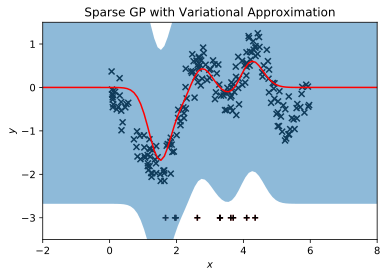

Iteration: 100 sigma_noise: 0.324, sigma_f: 0.379, length_scale: 0.588, free_energy: -90.119


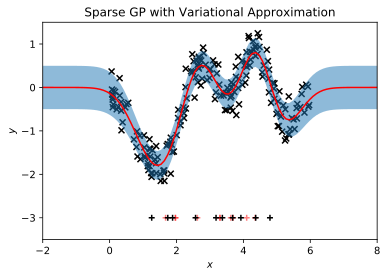

Iteration: 200 sigma_noise: 0.316, sigma_f: 0.375, length_scale: 0.528, free_energy: -83.841


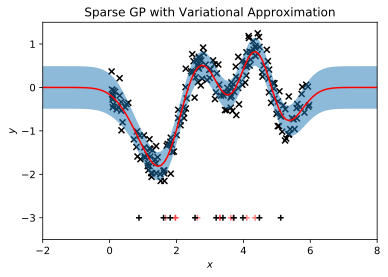

Iteration: 300 sigma_noise: 0.300, sigma_f: 0.493, length_scale: 0.616, free_energy: -71.323


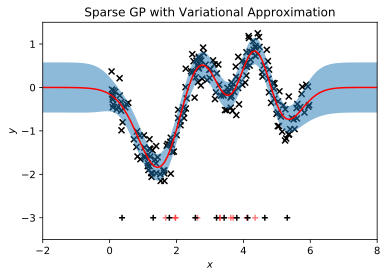

Iteration: 400 sigma_noise: 0.288, sigma_f: 0.704, length_scale: 0.658, free_energy: -60.555


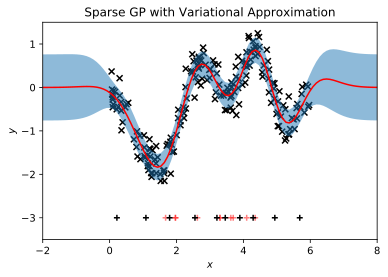

Iteration: 500 sigma_noise: 0.288, sigma_f: 0.783, length_scale: 0.671, free_energy: -59.584


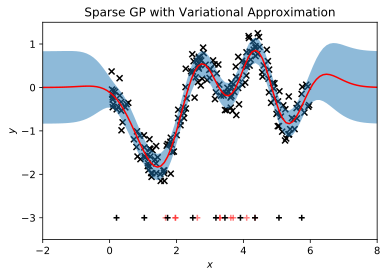

Iteration: 600 sigma_noise: 0.287, sigma_f: 0.820, length_scale: 0.677, free_energy: -59.270


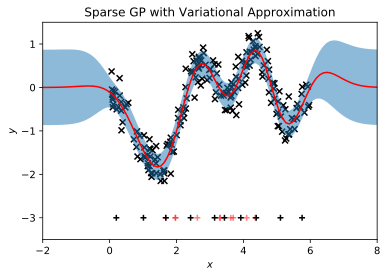

Iteration: 700 sigma_noise: 0.287, sigma_f: 0.842, length_scale: 0.680, free_energy: -59.069


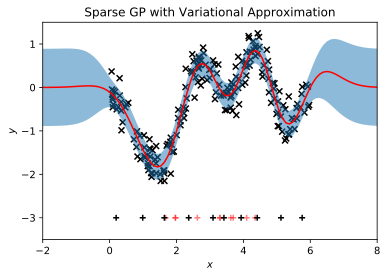

Iteration: 800 sigma_noise: 0.287, sigma_f: 0.855, length_scale: 0.681, free_energy: -58.903


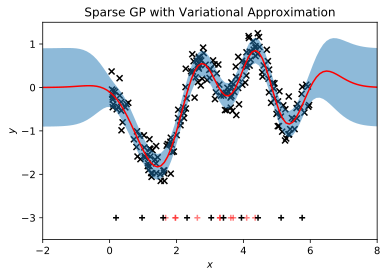

Iteration: 900 sigma_noise: 0.287, sigma_f: 0.862, length_scale: 0.680, free_energy: -58.749


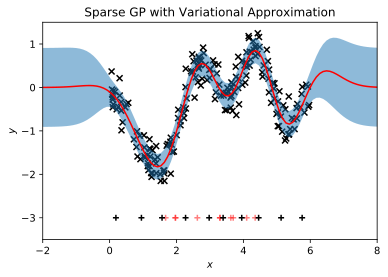

Iteration: 1000 sigma_noise: 0.287, sigma_f: 0.865, length_scale: 0.678, free_energy: -58.602


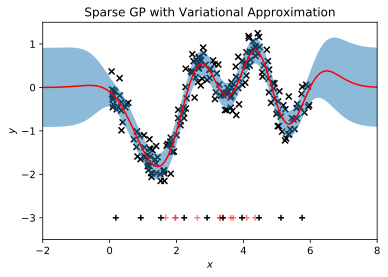

Iteration: 1100 sigma_noise: 0.287, sigma_f: 0.865, length_scale: 0.675, free_energy: -58.463


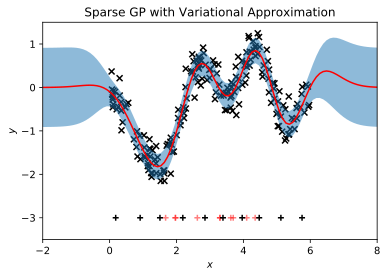

Iteration: 1200 sigma_noise: 0.287, sigma_f: 0.864, length_scale: 0.672, free_energy: -58.345


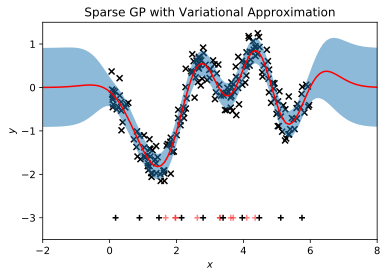

Early convergence at iteration 1214!


In [11]:
# Set seed for reproducibility
np.random.seed(42)

X_m = np.random.uniform(1.5, 4.5, 10).reshape((-1, 1))
X_m_init = X_m.copy()
print(X_m.shape)

for i, (X_m, log_sigma_noise, log_sigma_f, log_length_scale) in enumerate(fit_sgd(X_n, X_m, Y)):
    
    if i % 100 == 0:
        free_en = free_energy(X_n, X_m, Y, np.exp(log_sigma_noise), np.exp(log_sigma_f), np.exp(log_length_scale))
        print('Iteration:', i, 
              'sigma_noise: %.3f, sigma_f: %.3f, length_scale: %.3f, free_energy: %.3f'
               % (np.exp(log_sigma_noise), np.exp(log_sigma_f), np.exp(log_length_scale), free_en))
        
        mu_fn, cov_fn = get_predictive_variational_gp(X_m, X_n, Y, np.exp(log_sigma_noise), np.exp(log_sigma_f),
                                                      np.exp(log_length_scale))

        xs = np.linspace(-2., 8., 100)
        mus = np.array([mu_fn(np.array([[x]])) for x in xs])
        stds = np.array([cov_fn(np.array([[x]]))**0.5 for x in xs])

        plt.scatter(X_n, Y, marker='x', color='k')
        plt.scatter(X_m_init, -3 * np.ones_like(X_m_init), marker='+', color='r', alpha=0.5)
        plt.scatter(X_m, -3 * np.ones_like(X_m), marker='+', color='k')
        plt.plot(xs, mus.squeeze(), color='r')
        plt.fill_between(xs, (mus-stds).squeeze(), (mus+stds).squeeze(), alpha=.5)
        plt.title('Sparse GP with Variational Approximation')
        
        plt.xlim([-2., 8.])
        plt.ylim([-3.5, 1.5])
        plt.xlabel('$x$')
        plt.ylabel('$y$')
        plt.show()